In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error

In [2]:
ROOT = ""
#DESIRED_SIZE = 256 # Memory issue
DESIRED_SIZE = 128

In [3]:
tr = pd.read_csv(f"train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"test.csv")

print("add infos")
sub = pd.read_csv(f"sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [4]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [5]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [6]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [7]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [8]:
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [9]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [10]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [11]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [12]:
tr

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,...,0.0,1,0,1,0,0,0.769231,0.241456,0.179012,0.236393
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,...,9.0,1,0,1,0,0,0.769231,0.241456,0.234568,0.215941
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,...,11.0,1,0,1,0,0,0.769231,0.241456,0.246914,0.184960
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,...,13.0,1,0,1,0,0,0.769231,0.241456,0.259259,0.201767
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,...,15.0,1,0,1,0,0,0.769231,0.241456,0.271605,0.186580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,train,NaN,NaN,...,13.0,1,0,0,1,0,0.615385,0.354755,0.259259,0.303514
1531,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,train,NaN,NaN,...,19.0,1,0,0,1,0,0.615385,0.354755,0.296296,0.356076
1532,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,train,NaN,NaN,...,31.0,1,0,0,1,0,0.615385,0.354755,0.370370,0.342244
1533,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,train,NaN,NaN,...,43.0,1,0,0,1,0,0.615385,0.354755,0.444444,0.355484


In [13]:
def get_images(df, how="train"):
    xo = []
    p = []
    w  = []
    for i in tqdm(range(df.shape[0])):
        patient = df.iloc[i,0]
        week = df.iloc[i,1]
        try:
            img_path = f"{how}/{patient}/{week}.dcm"
            ds = pydicom.dcmread(img_path)
            im = Image.fromarray(ds.pixel_array)
            im = im.resize((DESIRED_SIZE,DESIRED_SIZE)) 
            im = np.array(im)
            xo.append(im[np.newaxis,:,:])
            p.append(patient)
            w.append(week)
        except:
            pass
    data = pd.DataFrame({"Patient":p,"Weeks":w})
    return np.concatenate(xo, axis=0), data

In [14]:
x, df_tr = get_images(tr, how="train")

100%|██████████| 1535/1535 [00:07<00:00, 199.84it/s]


In [15]:
x.shape, df_tr.shape

((1231, 128, 128), (1231, 2))

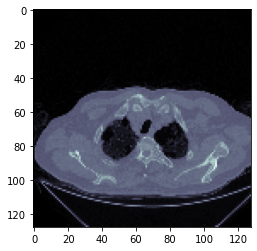

In [16]:
idx = np.random.randint(x.shape[0])
plt.imshow(x[idx], cmap=plt.cm.bone)
plt.show()

In [17]:
df_tr = df_tr.merge(tr, how="left", on=['Patient', 'Weeks'])

In [18]:
y = df_tr['FVC'].values
z = df_tr[FE].values

In [19]:
df_tr[FE]

,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,percent,week,BASE
0,1,0,1,0,0,0.769231,0.215941,0.234568,0.241456
1,1,0,1,0,0,0.769231,0.184960,0.246914,0.241456
2,1,0,1,0,0,0.769231,0.201767,0.259259,0.241456
3,1,0,1,0,0,0.769231,0.186580,0.271605,0.241456
4,1,0,1,0,0,0.769231,0.193059,0.308642,0.241456
...,...,...,...,...,...,...,...,...,...
1226,1,0,0,1,0,0.615385,0.303514,0.259259,0.354755
1227,1,0,0,1,0,0.615385,0.356076,0.296296,0.354755
1228,1,0,0,1,0,0.615385,0.342244,0.370370,0.354755
1229,1,0,0,1,0,0.615385,0.355484,0.444444,0.354755


In [20]:
y

array([2214, 2061, 2144, ..., 2908, 2975, 2774], dtype=int64)

In [21]:
z.shape

(1231, 9)

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def kloss(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 1]
    fvc_pred = y_pred[:, 0]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def kmae(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * kloss(y_true, y_pred) + (1 - _lambda)*kmae(y_true, y_pred)
    return loss
#=================
def make_model():
    inp = L.Input((DESIRED_SIZE,DESIRED_SIZE), name="input")
    z = L.Input((9,), name="Patient")
    x = L.Conv1D(50, 4, activation="relu", name="conv1")(inp)
    x = L.MaxPool1D(2, name='pool1')(x)
    
    #x = L.Dropout(0.2)(x)
    x = L.Conv1D(50, 4, activation="relu", name="conv2")(x)
    x = L.MaxPool1D(2, name='pool2')(x)
    
    #x = L.Dropout(0.2)(x)
    x = L.Conv1D(50, 4, activation="relu", name="conv3")(x)
    x = L.MaxPool1D(2, name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(50, activation="relu", name="d1")(x)
    l = L.Dense(10, activation="relu", name="d2")(z)
    x = L.Concatenate(name="combine")([x, l])
    x = L.Dense(50, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([inp, z], preds, name="CNN")
    model.compile(loss=mloss(0.5), optimizer="adam", metrics=[kloss])
    #model.compile(loss=kmae, optimizer="adam", metrics=[kloss])
    #model.compile(loss=kloss, optimizer="adam", metrics=[kmae])#
    return model